In [ ]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
! python --version

In [ ]:
! pip install POT

In [ ]:
! pip install --no-cache-dir --force-reinstall scikit-misc

In [ ]:
! pip install GraphST

In [1]:
!conda info --envs


# conda environments:
#
base                   D:\Anaconda
GraphSTenv           * D:\Anaconda\envs\GraphSTenv
myenv                  D:\Anaconda\envs\myenv



In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
import torch
import numpy as np
import scanpy as sc
import anndata
import rpy2
import pandas as pd
import scipy
import sklearn
import tqdm
import matplotlib

print("PyTorch version:", torch.__version__)
print(torch.__file__)
print("NumPy version:", np.__version__)
print("Scanpy version:", sc.__version__)
print("AnnData version:", anndata.__version__)
print("rpy2 version:", rpy2.__version__)
print("Pandas version:", pd.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TQDM version:", tqdm.__version__)
print("Matplotlib version:", matplotlib.__version__)


PyTorch version: 2.4.1+cu121
D:\Anaconda\envs\GraphSTenv\lib\site-packages\torch\__init__.py
NumPy version: 1.24.4
Scanpy version: 1.9.1
AnnData version: 0.8.0
rpy2 version: 3.4.1
Pandas version: 1.4.2
SciPy version: 1.8.1
Scikit-learn version: 1.1.1
TQDM version: 4.64.0
Matplotlib version: 3.4.2


In [3]:
from GraphST import GraphST

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device count: 1


In [5]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'D:/R/R-4.3.3'

In [7]:
# the number of clusters
n_clusters = 7

In [8]:
dataset = '151673'

In [56]:
# read data
file_fold = 'D:/Chrome downloads/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='151673_raw_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

D:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [57]:
adata.var_names_make_unique()

In [58]:
adata

AnnData object with n_obs × n_vars = 4992 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [59]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:12<00:00, 46.29it/s]

Optimization finished for ST data!


In [60]:
adata

AnnData object with n_obs × n_vars = 4992 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [18]:
import rpy2.robjects as robjects
robjects.r('install.packages("mclust", repos="http://cran.r-project.org")')

R[write to console]: trying URL 'http://cran.r-project.org/bin/windows/contrib/4.3/mclust_6.1.1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4119398 bytes (3.9 MB)

R[write to console]: downloaded 3.9 MB




package 'mclust' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\hyl01\AppData\Local\Temp\RtmpwrDyX4\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x0000021B0508B180> [RTYPES.NILSXP]

In [61]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


# Visualization

In [22]:
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
df_meta

,barcode,sample_name,tissue,row,col,imagerow,imagecol,Cluster,height,width,...,SpatialDE_PCA_spatial,SpatialDE_pool_PCA_spatial,HVG_PCA_spatial,pseudobulk_PCA_spatial,markers_PCA_spatial,SpatialDE_UMAP_spatial,SpatialDE_pool_UMAP_spatial,HVG_UMAP_spatial,pseudobulk_UMAP_spatial,markers_UMAP_spatial
AAACAACGAATAGTTC-1,AAACAACGAATAGTTC-1,151507,1,0,16,113.141318,147.434749,6,600,600,...,3,5,5,4,3,1,1,1,1,1
AAACAAGTATCTCCCA-1,AAACAAGTATCTCCCA-1,151507,1,50,102,383.438357,413.051319,3,600,600,...,4,1,2,3,1,2,2,1,2,1
AAACAATCTACTAGCA-1,AAACAATCTACTAGCA-1,151507,1,3,43,129.522957,231.008109,2,600,600,...,3,4,3,5,7,2,1,4,1,6
AAACACCAATAACTGC-1,AAACACCAATAACTGC-1,151507,1,59,19,431.188134,155.805586,5,600,600,...,7,6,7,7,7,7,8,7,8,1
AAACAGCTTTCAGAAG-1,AAACAGCTTTCAGAAG-1,151507,1,43,9,344.869499,125.067511,1,600,600,...,1,2,1,1,2,8,2,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,TTGTTGTGTGTCAAGA-1,151507,1,31,77,280.783088,335.913603,1,600,600,...,2,1,2,1,5,2,3,1,1,1
TTGTTTCACATCCAGG-1,TTGTTTCACATCCAGG-1,151507,1,58,42,426.012616,227.047713,3,600,600,...,1,1,1,1,1,3,2,2,1,1
TTGTTTCATTAGTCTA-1,TTGTTTCATTAGTCTA-1,151507,1,60,30,436.678683,189.828989,6,600,600,...,6,6,6,8,6,2,1,2,1,1
TTGTTTCCATACAACT-1,TTGTTTCCATACAACT-1,151507,1,45,27,355.805593,180.783085,3,600,600,...,1,1,2,1,2,2,2,1,1,1


In [62]:
df_meta = pd.read_csv(file_fold + "/metadata.tsv", sep="\t", index_col=0)  # 确保第一列是 barcode

# 计算交集
common_spots = adata.obs.index.intersection(df_meta.index)

# 只保留 `metadata.tsv` 里有的 spots
adata = adata[common_spots].copy()

# 检查最终数据形状
print("Filtered adata shape:", adata.shape)

Filtered adata shape: (4226, 33538)


In [63]:
# add ground_truth
adata.obs['ground_truth'] = df_meta_layer.values

In [64]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

D:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.11536816058239857


In [65]:
print("Spatial X range:", np.min(adata.obsm["spatial"][:, 0]), "to", np.max(adata.obsm["spatial"][:, 0]))
print("Spatial Y range:", np.min(adata.obsm["spatial"][:, 1]), "to", np.max(adata.obsm["spatial"][:, 1]))

Spatial X range: 2776 to 11555
Spatial Y range: 2434 to 11695


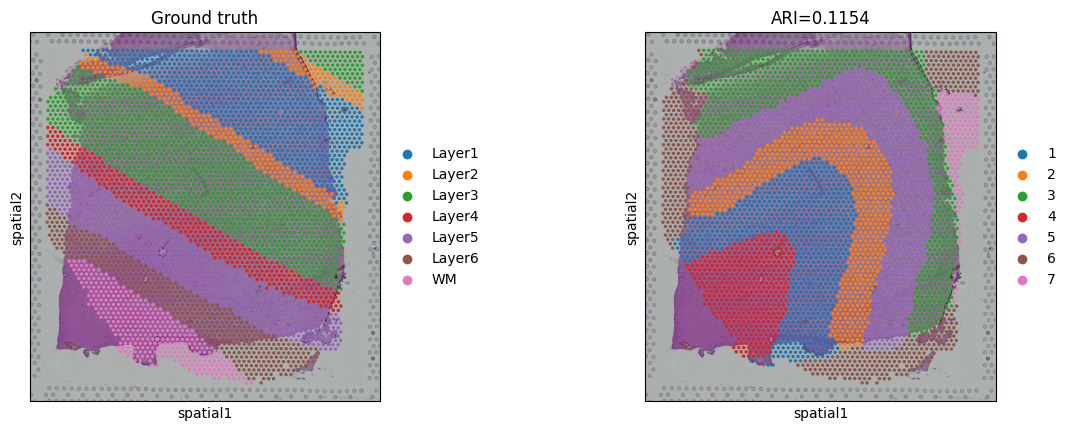

In [66]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

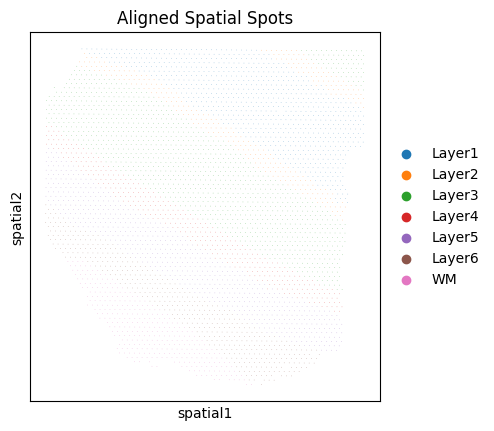

In [67]:
# 获取 tissue_hires_scalef 进行缩放
scalefactor = adata.uns["spatial"]["151673"]["scalefactors"]["tissue_hires_scalef"]
# 确保数据类型是 float64
adata.obsm["spatial"] = adata.obsm["spatial"].astype(float)
# 乘以缩放因子

# 重新缩放坐标
adata.obsm["spatial"] *= (1 / scalefactor)  # 用 1/scalefactor 反向缩放

# 重新绘制图像
import scanpy as sc
sc.pl.spatial(
    adata,
    img_key="hires",
    color="ground_truth",
    #spot_size=30,  # 可能需要调整大小
    title="Aligned Spatial Spots"
)

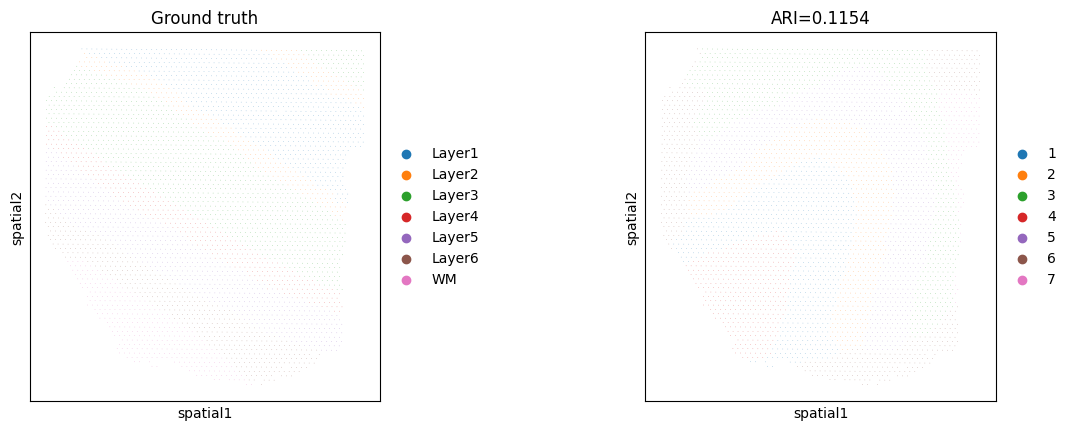

In [69]:
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

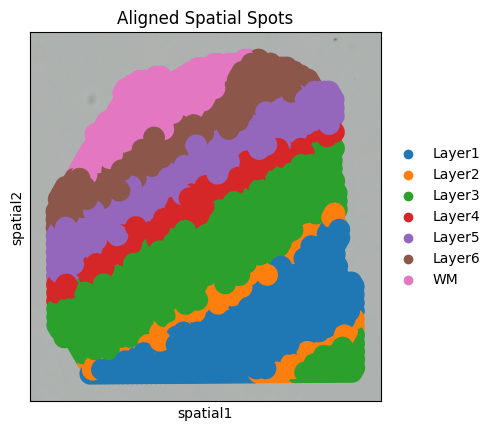

In [55]:
hires_shape = adata.uns["spatial"]["151673"]["images"]["hires"].shape
adata.obsm["spatial"][:, 1] = hires_shape[0] - adata.obsm["spatial"][:, 1]

sc.pl.spatial(
    adata,
    img_key="hires",
    color="ground_truth",
    #spot_size=30,  # 可能需要调整大小
    title="Aligned Spatial Spots"
)

In [32]:
adata.obsm["spatial"] = (adata.obsm["spatial"] - np.min(adata.obsm["spatial"], axis=0)) / \
                        (np.max(adata.obsm["spatial"], axis=0) - np.min(adata.obsm["spatial"], axis=0))

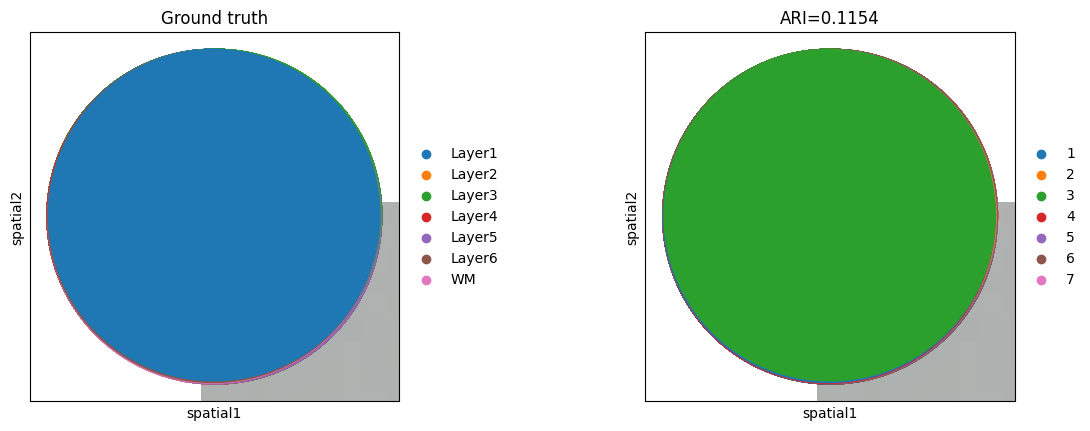

In [33]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

D:\Anaconda\envs\GraphSTenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

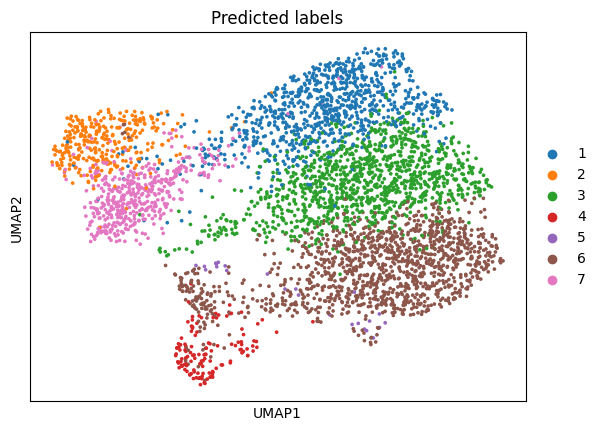

In [23]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)